Francesco Vo

2079413

The Fashion MNIST dataset is a dataset that consists of small images of clothing items. It contains 70,000 greyscale images and each image is 28 x 28 pixels; each image is associated with a label indicating the category of clothing it represents, ranging from 0 to 9.

The goal of this project is to correctly classify the category of a given image (image classification).

To do that we will train a Deep Belief Network (DBN) on this dataset. A DBN is a deep learning model that consists of multiple layers of latent variables, typically in an unsupervised learning setting. DBNs are composed of stacked layers of Restricted Boltzmann Machines (RBMs).

# Setup
We start by loading the dataset and we visualize some images.

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/Cognition and computation/final-project'

/content/drive/MyDrive/Colab Notebooks/Cognition and computation/final-project


In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import math
import matplotlib.pyplot as plt
import sklearn.preprocessing
import torch
import torch.nn.functional as functional
import torchvision as tv
import scipy.cluster as cluster

from DBN import DBN
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


In [ ]:
transformer = tv.transforms.Compose([tv.transforms.ToTensor()])

In [ ]:
%%capture
data_train = tv.datasets.FashionMNIST('data/', train=True, download=True,
                                              transform=transformer)

data_test = tv.datasets.FashionMNIST('data/', train=False, download=True,
                                             transform=transformer)

In [ ]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [ ]:
data_loader = torch.utils.data.DataLoader(data_train, batch_size=4, shuffle=True)
sample = next(iter(data_loader))
images, labels = sample

In [ ]:
# data normalization
data_train.data = (data_train.data.type(torch.FloatTensor)/255)
data_test.data = (data_test.data.type(torch.FloatTensor)/255)

image tensor: torch.Size([4, 1, 28, 28])
class labels: tensor([7, 5, 4, 6])


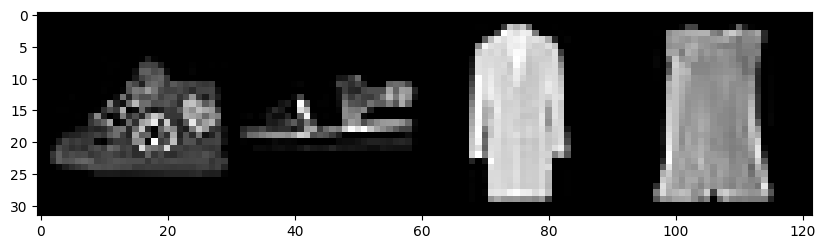

In [ ]:
plt.figure(figsize=(10, 10))
grid = tv.utils.make_grid(nrow=20, tensor=images)
print(f"image tensor: {images.shape}")
print(f"class labels: {labels}")
plt.imshow(np.transpose(grid, axes=(1, 2, 0)), cmap='gray')

In [ ]:
data_train.data = data_train.data.to(device)
data_test.data = data_test.data.to(device)
data_train.targets = data_train.targets.to(device)
data_test.targets = data_test.targets.to(device)

# Model Training

The DBN used for this project consists of 3 layers defined in this way:

- First Layer: 400 Neurons

- Second Layer: 256 Neurons

- Third Layer: 128 Neurons

In [ ]:
hidden_units = [400, 650, 650]
learning_rate = 0.1
num_epochs = 50
batch_size = 120

In [ ]:
dbn_fmnist = DBN(visible_units=28*28,
                hidden_units=hidden_units,
                k=1,
                learning_rate=learning_rate,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [ ]:
dbn_fmnist.train_static(
    data_train.data,
    data_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.7888     |0.0827       |311.8777   |6.3008     |
|20    |1.6780     |0.0810       |296.2099   |5.2248     |
|30    |1.6501     |0.0794       |293.0685   |5.1971     |
|40    |1.6377     |0.0781       |289.6778   |5.0298     |
|50    |1.6334     |0.0783       |284.5659   |5.7152     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0059     |0.0356       |149.4720   |2.9596     |
|20    |0.9369     |0.0323       |139.5226   |2.2320     |
|30    |0.9194     |0.0328       |135.8878   |2.2685     |
|40    |0.9123     |0.0302       |134.4381   |1.9978     |
|50    |0.9057     |0.0309       |133.5040   |2.1760     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.6177     |0.0227       |157.7633   |3.0522     |
|20    |0.5436     |0.0179       |144.9242   |2.270

In [ ]:
# save the model
dir = os.getcwd()

model_path = "model.pth"

In [ ]:
torch.save(dbn_fmnist.state_dict(), model_path)

In [ ]:
dbn_fmnist = torch.load("model.pth") # TODO: this is wrong!

# Receptive fields
A receptive field refers to the region of the input data that a particular neuron or unit in a neural network is sensitive to. It represents the portion of the input space that influences the activation of that neuron.

Visualizing the receptive field offers insights into the network's connectivity matrix, represented in a two-dimensional space of 28 × 28 pixels. The grayscale values within each receptive field depict the strength of connections between neurons, thereby capturing distinct visual concepts.

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)

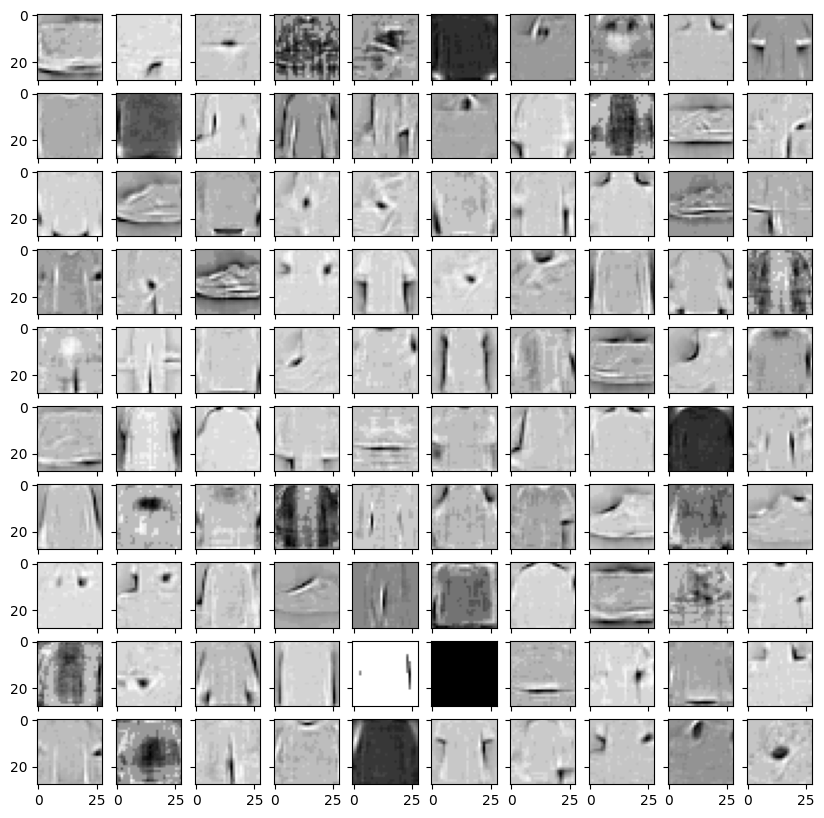

In [ ]:
w1 = get_weights(dbn_fmnist, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

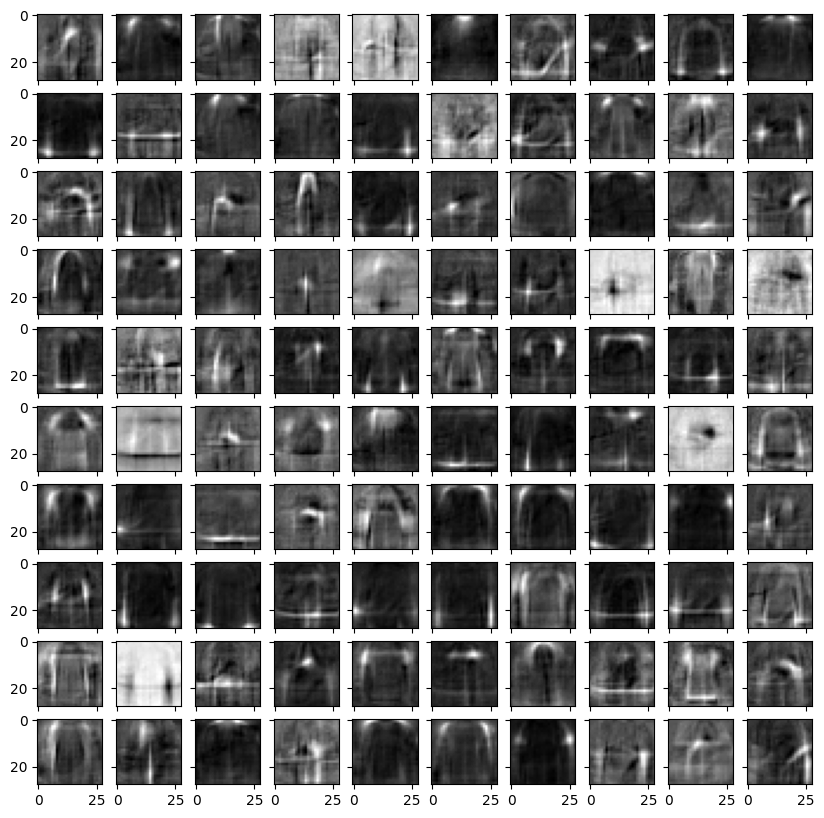

In [ ]:
w1 = get_weights(dbn_fmnist, layer=0)
w2 = get_weights(dbn_fmnist, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

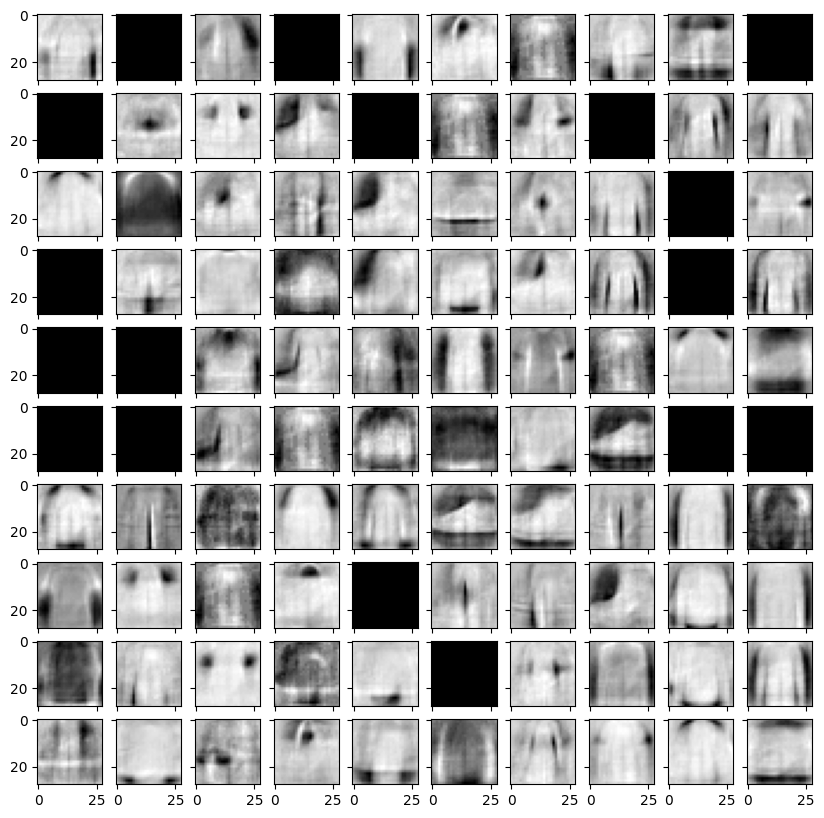

In [ ]:
w1 = get_weights(dbn_fmnist, layer=0)
w2 = get_weights(dbn_fmnist, layer=1)
w3 = get_weights(dbn_fmnist, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)
w_product_23 = (w_product_12 @ w3)
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

The visualization of the receptive fields shows how unsupervised models progressively capture finer details as we go deeper into the layers.

The second layer shows bright lines and dots in a dark background compared to the first layer. This shows that in deeper layers individual neurons are assigned to more specialized functions.

# Clustering internal representation
"Clustering internal representation" refers to the way data points are internally organized or represented within a clustering algorithm. Clustering is an unsupervised machine learning technique where the goal is to partition a dataset into groups or clusters such that data points within the same cluster are more similar to each other than to those in other clusters.

When you perform clustering, the algorithm assigns each data point to a particular cluster based on certain criteria, such as proximity or similarity. The internal representation of this process refers to how the algorithm internally represents and stores information about the clusters and their relationships with the data points.

The purpose of this code is to visualize the relationships between different classes in the neural network by clustering their mean hidden representations. The dendrogram produced by the clustering algorithm can help interpret the structure of the hidden representations.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fmnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
hidden_repr_1 = get_kth_layer_repr(data_train.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)

torch.Size([60000, 400])


In [ ]:
def get_mask(label):
  labels = data_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)
    for label in range(10)])

In [ ]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

In [34]:
def plot_dendrogram(mean_repr_matrix, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")
    dendrogram = cluster.hierarchy.dendrogram(linkage, labels=classes)
    ax.set_title(title)
    plt.xticks(rotation=45)  # Rotate labels to 45 degrees
    plt.tight_layout()  # Adjust layout to make room for the x-labels
    plt.show()

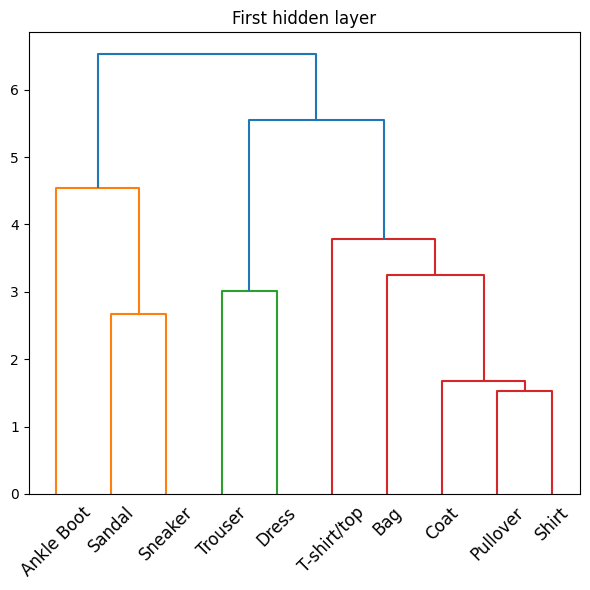

In [35]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

We can see that in the first hidden layer that the shoes are well clustered together. This is also true for the shirts but inside that cluster we have also the class "Bag" which doesn't show many similarities with the others.

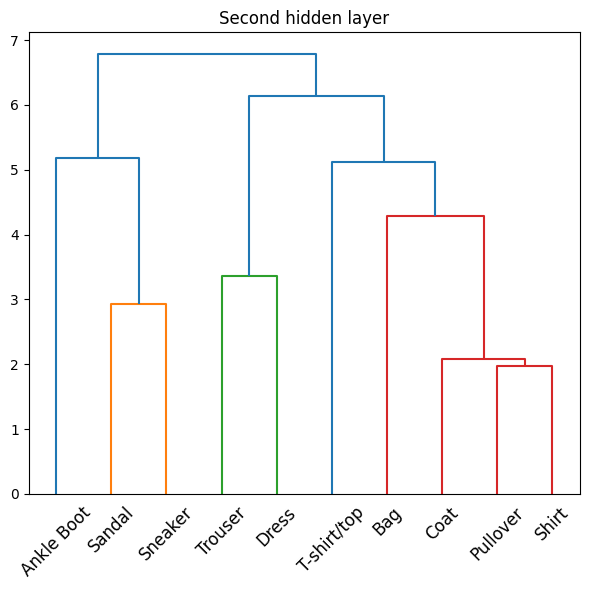

In [36]:
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

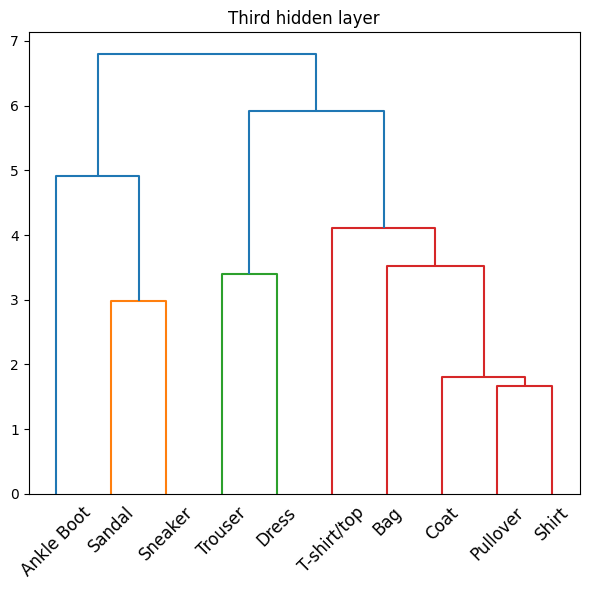

In [37]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

# Linear read-out
In the context of Deep Belief Networks (DBNs), "linear read-out" refers to the process of using the activations of the hidden layers of the DBN to make predictions or perform classification tasks. It's a way of extracting useful information from the hierarchical representation learned by the DBN.

In [38]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [39]:
layer_size = dbn_fmnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_fmnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_fmnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

For training the learning rate equal to 0.05 is the best

In [40]:
linear_lr = 0.05
linear_epochs = 2000

In [41]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=linear_lr)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = linear_epochs

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = data_train.targets.reshape(predictions.shape[0])
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [42]:
train_linear(linear1, hidden_repr_1)

epoch :   1/2000, loss = 2.3424
epoch : 101/2000, loss = 0.9428
epoch : 201/2000, loss = 0.7364
epoch : 301/2000, loss = 0.6537
epoch : 401/2000, loss = 0.6062
epoch : 501/2000, loss = 0.5741
epoch : 601/2000, loss = 0.5505
epoch : 701/2000, loss = 0.5321
epoch : 801/2000, loss = 0.5173
epoch : 901/2000, loss = 0.5049
epoch : 1001/2000, loss = 0.4945
epoch : 1101/2000, loss = 0.4854
epoch : 1201/2000, loss = 0.4776
epoch : 1301/2000, loss = 0.4706
epoch : 1401/2000, loss = 0.4644
epoch : 1501/2000, loss = 0.4588
epoch : 1601/2000, loss = 0.4537
epoch : 1701/2000, loss = 0.4490
epoch : 1801/2000, loss = 0.4448
epoch : 1901/2000, loss = 0.4409


In [43]:
train_linear(linear2, hidden_repr_2)

epoch :   1/2000, loss = 2.3216
epoch : 101/2000, loss = 0.8069
epoch : 201/2000, loss = 0.6536
epoch : 301/2000, loss = 0.5903
epoch : 401/2000, loss = 0.5529
epoch : 501/2000, loss = 0.5272
epoch : 601/2000, loss = 0.5081
epoch : 701/2000, loss = 0.4932
epoch : 801/2000, loss = 0.4811
epoch : 901/2000, loss = 0.4711
epoch : 1001/2000, loss = 0.4626
epoch : 1101/2000, loss = 0.4554
epoch : 1201/2000, loss = 0.4490
epoch : 1301/2000, loss = 0.4434
epoch : 1401/2000, loss = 0.4384
epoch : 1501/2000, loss = 0.4339
epoch : 1601/2000, loss = 0.4298
epoch : 1701/2000, loss = 0.4261
epoch : 1801/2000, loss = 0.4227
epoch : 1901/2000, loss = 0.4196


In [44]:
train_linear(linear3, hidden_repr_3)

epoch :   1/2000, loss = 2.2933
epoch : 101/2000, loss = 0.8626
epoch : 201/2000, loss = 0.6834
epoch : 301/2000, loss = 0.6114
epoch : 401/2000, loss = 0.5698
epoch : 501/2000, loss = 0.5418
epoch : 601/2000, loss = 0.5212
epoch : 701/2000, loss = 0.5053
epoch : 801/2000, loss = 0.4925
epoch : 901/2000, loss = 0.4820
epoch : 1001/2000, loss = 0.4731
epoch : 1101/2000, loss = 0.4655
epoch : 1201/2000, loss = 0.4588
epoch : 1301/2000, loss = 0.4530
epoch : 1401/2000, loss = 0.4477
epoch : 1501/2000, loss = 0.4431
epoch : 1601/2000, loss = 0.4388
epoch : 1701/2000, loss = 0.4350
epoch : 1801/2000, loss = 0.4315
epoch : 1901/2000, loss = 0.4282


In [45]:
hidden_repr_1_test = get_kth_layer_repr(data_test.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

In [46]:
# compute the classifier predictions:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

In [47]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [48]:
compute_accuracy(predictions_test1, data_test.targets)

0.8392999768257141

In [49]:
compute_accuracy(predictions_test2, data_test.targets)

0.8453999757766724

In [50]:
compute_accuracy(predictions_test3, data_test.targets)

0.8434000015258789

# Feed-forward model comparison
Now we compare the performances of the DBN with a FFNN.

In [51]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [52]:
def train_supervised(network, input_data, epochs=linear_epochs):
  optimizer = torch.optim.SGD(network.parameters(), lr=linear_lr)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input_data).squeeze()
    targets = data_train.targets.reshape(predictions.shape[0])
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [53]:
ffnn = Feedforward(400, 650, 650).to(device) # we keep the same structure

In [54]:
train_supervised(ffnn, data_train.data.reshape((60000, 784)))

epoch :   1/2000, loss = 2.3042
epoch : 101/2000, loss = 1.4273
epoch : 201/2000, loss = 0.9398
epoch : 301/2000, loss = 0.7873
epoch : 401/2000, loss = 0.6920
epoch : 501/2000, loss = 0.6222
epoch : 601/2000, loss = 0.5749
epoch : 701/2000, loss = 0.5557
epoch : 801/2000, loss = 0.5248
epoch : 901/2000, loss = 0.5370
epoch : 1001/2000, loss = 0.5133
epoch : 1101/2000, loss = 0.4739
epoch : 1201/2000, loss = 0.4579
epoch : 1301/2000, loss = 0.4478
epoch : 1401/2000, loss = 0.4417
epoch : 1501/2000, loss = 0.4367
epoch : 1601/2000, loss = 0.4342
epoch : 1701/2000, loss = 0.4267
epoch : 1801/2000, loss = 0.4123
epoch : 1901/2000, loss = 0.4054


In [ ]:
torch.save(ffnn.state_dict(), "ffmodel.pth")

In [55]:
predictions_ffnn = ffnn(data_test.data.reshape((10000, 784)))

In [56]:
compute_accuracy(predictions_ffnn, data_test.targets)

0.840499997138977

The performances are the same compared to the DBN.

# Confusion matrices

In [60]:
def conf_mat_print(predictions_test, cmap="Blues"):
  true_labels = data_test.targets.to(device).cpu().numpy()
  pred_labels = predictions_test.cpu().detach().max(axis=1).indices.numpy()

  conf_mat = confusion_matrix(true_labels, pred_labels)

  df_cm = pd.DataFrame(conf_mat / np.sum(conf_mat) * 10, index=[i for i in classes], columns=[i for i in classes])
  plt.figure(figsize=(10, 8))
  sn.heatmap(df_cm, cmap=cmap, annot=True)

  print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1000
           1       0.98      0.94      0.96      1000
           2       0.73      0.75      0.74      1000
           3       0.82      0.87      0.85      1000
           4       0.75      0.75      0.75      1000
           5       0.96      0.91      0.94      1000
           6       0.61      0.55      0.58      1000
           7       0.90      0.92      0.91      1000
           8       0.93      0.95      0.94      1000
           9       0.91      0.95      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



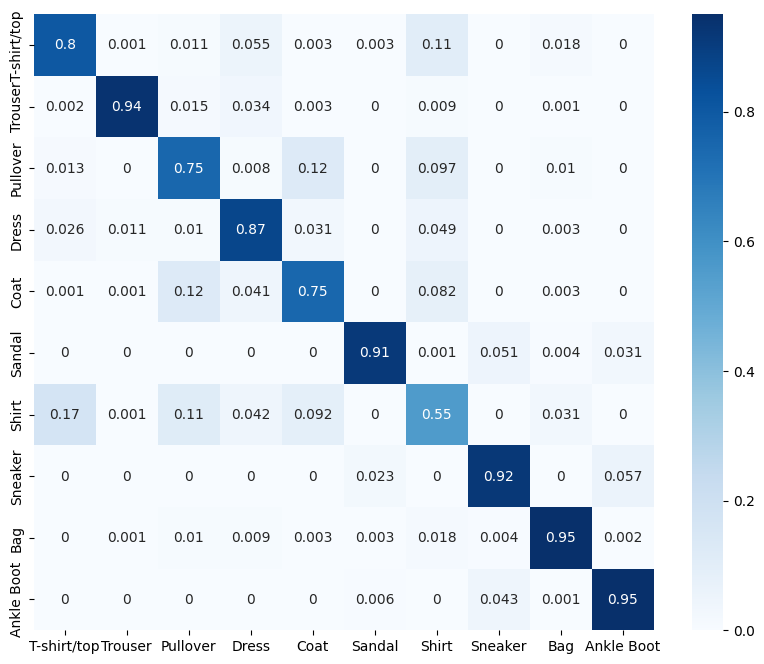

In [61]:
conf_mat_print(predictions_test1)

We can see that the model performs very well for some classes and poorly for others (in this case the class "Shirt"). This pattern can be seen for the other layers and also in the FFNN.

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1000
           1       0.99      0.95      0.97      1000
           2       0.74      0.75      0.74      1000
           3       0.83      0.88      0.85      1000
           4       0.74      0.75      0.75      1000
           5       0.96      0.92      0.94      1000
           6       0.63      0.57      0.60      1000
           7       0.91      0.92      0.92      1000
           8       0.94      0.95      0.95      1000
           9       0.92      0.95      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.84      0.85      0.84     10000
weighted avg       0.84      0.85      0.84     10000



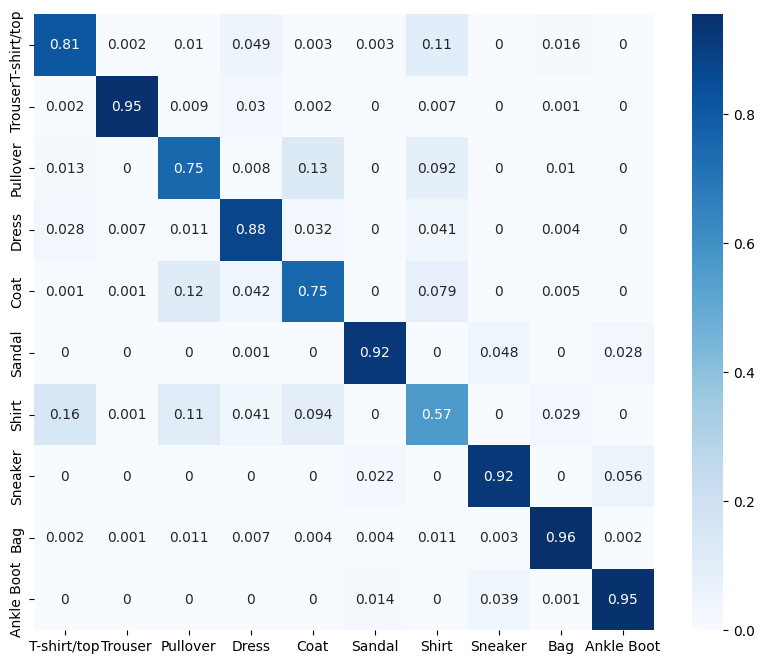

In [62]:
conf_mat_print(predictions_test2)

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      1000
           1       0.99      0.94      0.96      1000
           2       0.74      0.75      0.74      1000
           3       0.83      0.88      0.86      1000
           4       0.75      0.76      0.75      1000
           5       0.97      0.92      0.94      1000
           6       0.61      0.55      0.58      1000
           7       0.91      0.92      0.91      1000
           8       0.94      0.96      0.95      1000
           9       0.91      0.95      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



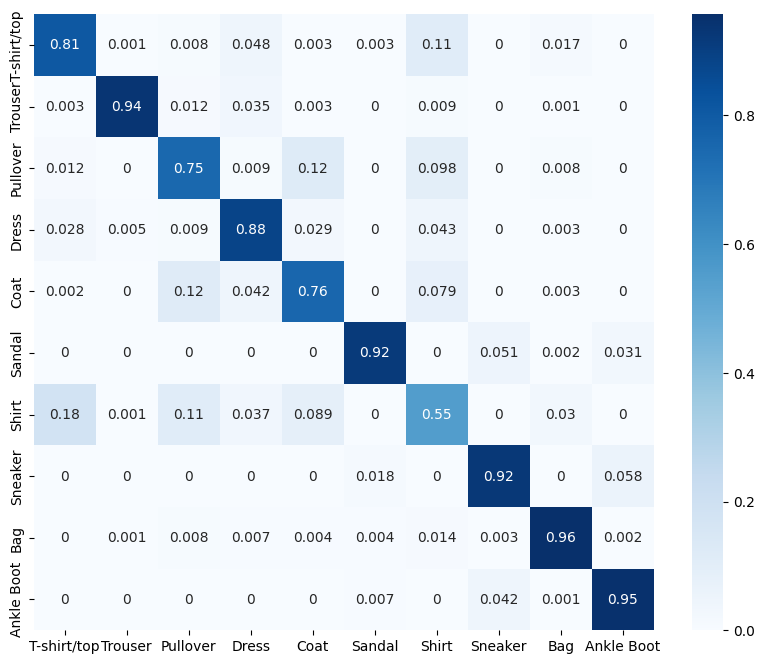

In [63]:
conf_mat_print(predictions_test3)

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1000
           1       0.97      0.96      0.96      1000
           2       0.72      0.75      0.73      1000
           3       0.83      0.87      0.85      1000
           4       0.66      0.84      0.74      1000
           5       0.95      0.92      0.94      1000
           6       0.72      0.40      0.52      1000
           7       0.90      0.93      0.92      1000
           8       0.93      0.95      0.94      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.83     10000
weighted avg       0.84      0.84      0.83     10000



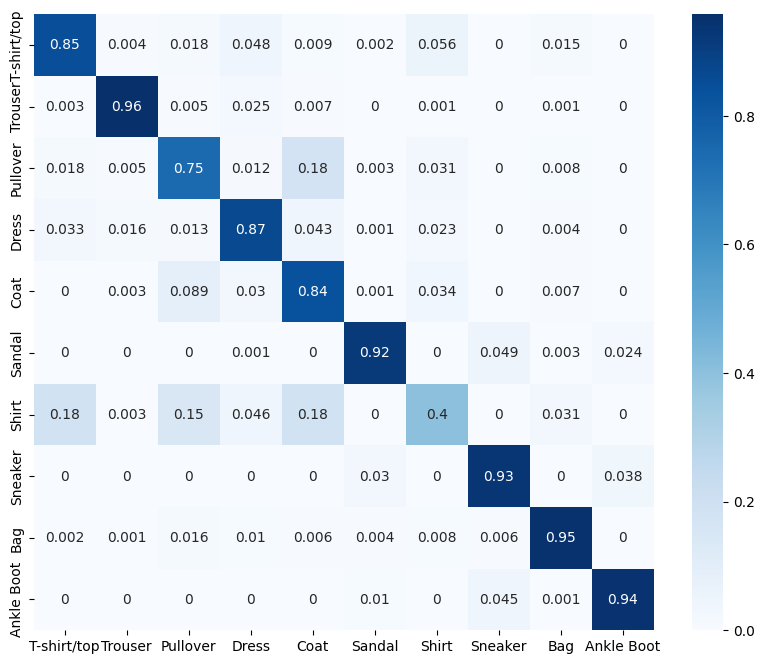

In [64]:
conf_mat_print(predictions_ffnn)

# Psychometric curves
Psychometric curves in deep learning are metrics used to assess a neural network's performance relative to human perception and decision-making. They evaluate tasks like image recognition, plotting the model's accuracy or sensitivity against task difficulty (in this case the level of noise in the image). These curves help gauge how well a model aligns with human behavior in perceptual and cognitive tasks.

To compare the performance of the models, various levels of noise ranging from 0 to 1.3 are injected into the images of the test dataset. The accuracy of different models is then calculated and reported in a graph.

The type of noise used is Gaussian noise.

In [65]:
def inject_noise(fmnist_data, noise_level):

  noise = torch.randn_like(fmnist_data) * noise_level
  noisy_data = fmnist_data + noise
  return noisy_data

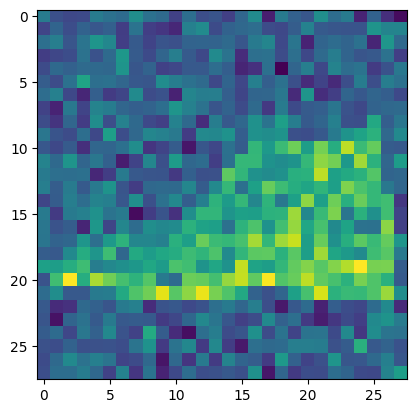

In [66]:
noise_level = 0.2
fmnist_test_with_noise = inject_noise(data_test.data, noise_level)
__ = plt.imshow(fmnist_test_with_noise[0].reshape(28, 28).to("cpu"))

In [68]:
def get_accuracy_values_at_noise_level(noise_level):

  mnist_test_with_noise = inject_noise(data_test.data, noise_level)  # first, let's create noisy test images

  hidden_repr_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, data_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, data_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, data_test.targets)

  mnist_test_with_noise_ffnn = mnist_test_with_noise.view(mnist_test_with_noise.size(0), -1)

  predictions_ffnn = ffnn(mnist_test_with_noise_ffnn)

  accuracy_ffnn = compute_accuracy(predictions_ffnn, data_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [69]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.806
Accuracy of H2 read-out: 0.826
Accuracy of H3 read-out: 0.826
Accuracy of FF network : 0.800


In [70]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

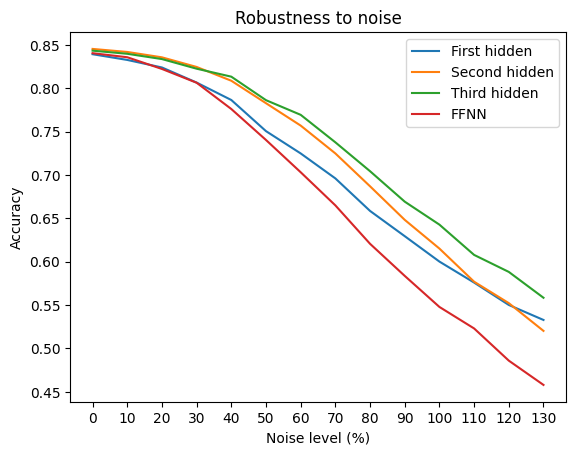

In [71]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

It has been noted that perceptrons, trained on hidden representations, exhibit superior performance compared to the Feedforward Neural Network (FFNN) model under Gaussian noise, exceeding with 10% accuracy.

Moreover, even the perceptron trained on internal representations of the first hidden layer outperforms the FFNN model. This underscores the significance of representations learned by Deep Belief Network (DBN) models in facilitating the learning of generalized patterns resembling simple shapes found in natural data.

# Adversarial attacks
Adversarial attacks refer to the phenomenon where small, carefully crafted perturbations are added to input data with the goal of causing misclassification by a neural network model. These perturbations are often imperceptible to humans but can lead to significant changes in the model's output.

We want to see how resilient are the trained models on those kind of attacks by evaluating the performances on the attacked dataset.

In this case we implement the FGSM attack, which perturbs the input data in the direction of the gradient of the loss function with respect to the input. Mathematically, its computed as:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [72]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

In [73]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM activations
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [74]:
dbn_with_readout = DBNWithReadOut(dbn_fmnist, [linear1, linear2, linear3], readout_level=2)

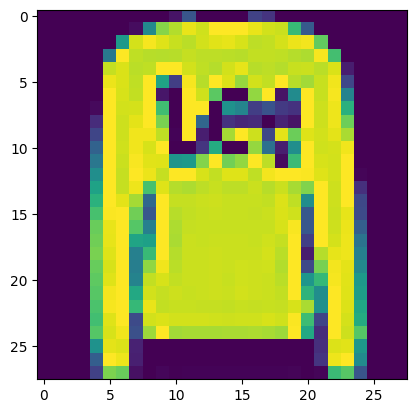

In [75]:
test_sample_idx = 1
test_image = data_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

In [76]:
attacked_model = ffnn

In [77]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image.to(device))
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 2.


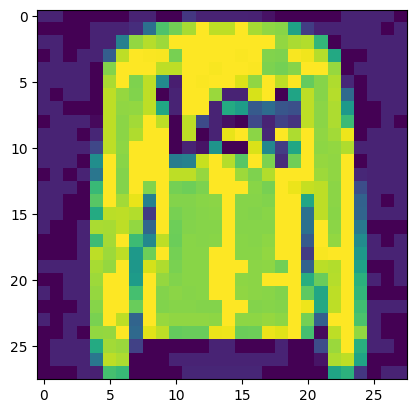

In [78]:
# We define strenght of the attack
epsilon = 0.1

# Get the ground truth label for that image
test_image_label = data_test.targets[test_sample_idx].unsqueeze(0)

# Get the loss value
loss_value = torch.nn.functional.cross_entropy(model_outputs.to(device), test_image_label.to(device))
attacked_model.zero_grad()
loss_value.backward()

# Get the gradient of the pixels w.r.t. the loss
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [79]:
model_outputs = attacked_model(perturbed_image.to(device).view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 6.


## Resist the attack

In [80]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0  # if we request for top-down reconstruction, print the result

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # we need to get the gradient to perform the attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient with respect to the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [81]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=False,
                             transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [82]:
final_acc1 = test_robustness_to_attack(ffnn, device, test_loader, epsilon=0.05, num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.05
Test Accuracy: 57.28%



In [83]:
final_acc2 = test_robustness_to_attack(dbn_with_readout, device, test_loader, epsilon=0.05, num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.05
Test Accuracy: 68.57%



  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



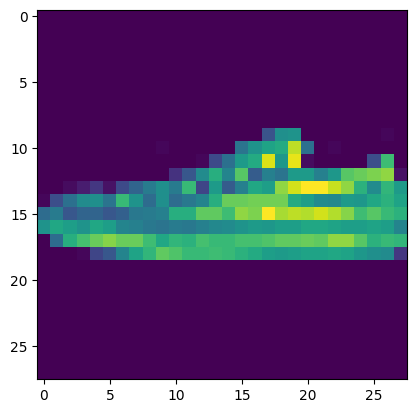


Here's a perturbed sample:



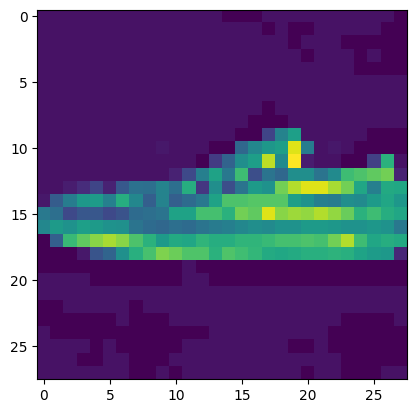


Here's what a 1-steps reconstructed sample looks like:



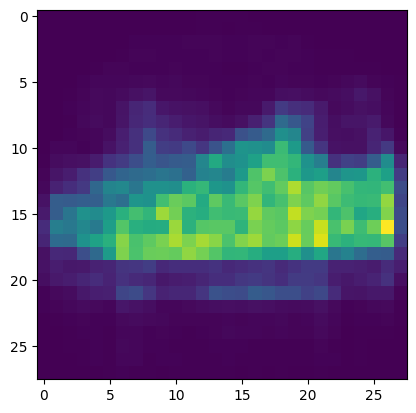


Epsilon: 0.05
Test Accuracy: 67.50%



In [84]:
final_acc2 = test_robustness_to_attack(dbn_with_readout, device, test_loader, epsilon=0.05, num_steps=1)

In [85]:
epsilon_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]


def test_epsilon_values_effect(model, n_steps):
    accuracies = list()

    for eps in epsilon_values:
        acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
        accuracies.append(acc)

    return accuracies

In [86]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

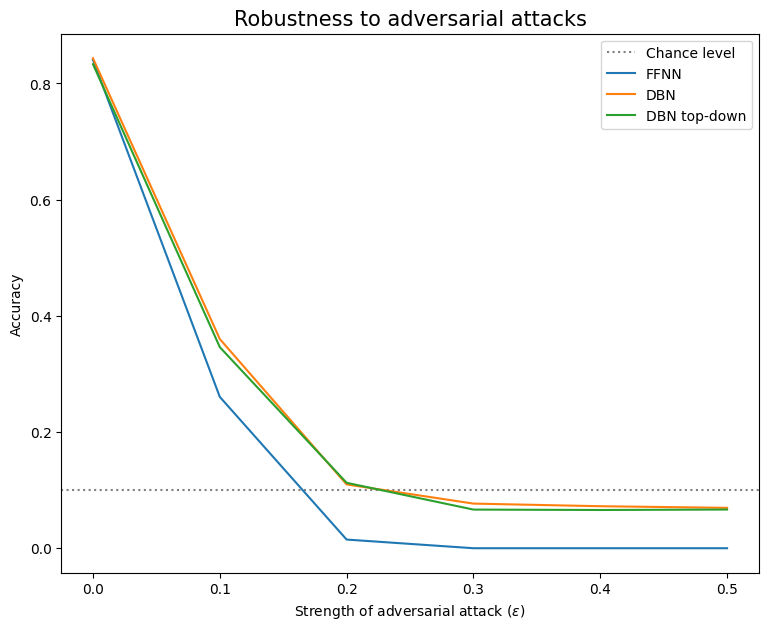

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

As a result, robustness to adversarial attacks in the DBN is better than the FFNN model and it can resist better against attacks even if we increase the strength of attack.